# Kinematic Car

kinematic model of a car

In [320]:
import logging
import sys
import os
import math
import matplotlib.pyplot as plt
import numpy as np

(0.0, 50.0, -25.0, 25.0)

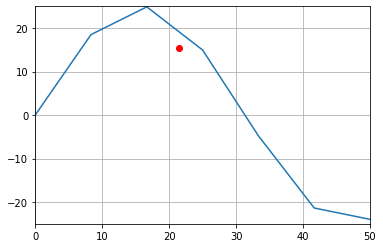

In [553]:
# make the path
xs = np.linspace(0.0,50.0,7)
ys = 25.0*np.sin(xs/10.0)
pnts = np.vstack((xs,ys))

car_p = pnts[:,3] + np.array((-3.5,0.5))

plt.plot(xs,ys)
plt.grid()
plt.plot(car_p[0], car_p[1], 'ro')
plt.axis([0,50,-25,25])

In [607]:
# make path segment class
class PathSegment:
    # path segments consist of a node and the edge that preceeds it
    # calculate the desired speed at the node and use the preceeding edge to adjust to the desired speed
    # ------A ------B ------C
    us = np.zeros((2,1)) # unit vector in global frame
    length_m = 0.0 # length in meters
    speed = 2.0 # speed in meters/sec 2.0 m/s ~= 4.5 mph
    max_speed = 2.0
    max_entry_speed = 2.0
    radius_of_curvature = 1000.0 #used to get max speed
    p = np.zeros((2,1)) # starting point
    dt = 0.0 # time to cross it
    centripetal_acceleration = 0.0 # centripetal acceletation (m^/s^2)
    linear_acceleration = 0.0

    def __init__(self, index, pnts):
        self.index = index
        self.p = pnts[:,index]
        self.speed = 1.0 # initial estimate

        if index > 0:
            pm1 = pnts[:,index-1]
            self.length_m = np.linalg.norm(self.p-pm1)
            self.unit_vector = (self.p - pm1) / self.length_m
            self.dt = self.length_m / self.speed
            
        else:
            self.length_m = 0.1
            self.unit_vector = (pnts[:,index+1] - self.p) / self.length_m
            self.dt = self.length_m / self.speed
        
    def cout(self):
        print("****************")
        print("index: ", self.index)
        print("p: ", self.p)
        print("p1: ", self.p1)
        print("unit_vector: ", self.unit_vector)
        print("l: ", self.length_m)
        print("speed: ", self.speed)
        print("max speed: ", self.centr_accel_lim_speed)
        print("max entry speed: ", self.entry_speed)
        print("dt: ", self.dt)
        print("gradient: ", self.grad)
        print("centripetal acceleration: ", self.centripetal_acceleration)
        print("linear acceleration: ", self.linear_acceleration)
    
    
    def computeRadiusOfCurvature(self, si, path):
        # this uses the midpoint of the current segment and the points on either side to estimate the radius of curvature at this point in the path
        z1 = 0 + 0j
        z2 = 0 + 0j
        z3 = 0 + 0j
        # verify I am a middle point
        if si > 0 and si < len(path)-1:
            # z1 = previous segment
            z1 = complex(path[si-1].p[0], path[si-1].p[1])
            # z2 = current segment
            z2 = complex(self.p[0], self.p[1])
            # z3 = next segment
            z3 = complex(path[si+1].p[0], path[si+1].p[1])
        
        # if I am the start point
        elif si == 0 and si < len(path)-2:
            # z1 = current segment
            z1 = complex(self.p[0], self.p[1])
            # z2 = next segment
            z2 = complex(path[si+1].p[0], path[si+1].p[1])
            # z3 = following segment
            z3 = complex(path[si+2].p[0], path[si+2].p[1])
            
        # I am the end point
        elif si > 1 and si == len(path)-1:
            # z1 = current segment
            z1 = complex(self.p[0], self.p[1])
            # z2 = previous segment
            z2 = complex(path[si-1].p[0], path[si-1].p[1])
            # z3 = previous segment
            z3 = complex(path[si-2].p[0], path[si-2].p[1])
            
            
        else:
            # there is something wrong with the path
            raise ValueError("Path is not of correct type")
        
        # https://math.stackexchange.com/questions/213658/get-the-equation-of-a-circle-when-given-3-points#:~:text=Follow%20these%20steps%3A%201%20Consider%20the%20general%20equation,%E2%88%92%20yc%292%20%E2%88%92%20r2%20%3D%200%20More%20items
        if (z1 == z2) or (z2 == z3) or (z3 == z1):
            raise ValueError(f"Duplicate points: {z1}, {z2}, {z3}")
            
        w = (z3 - z1)/(z2 - z1)
        
        # You should change 0 to a small tolerance for floating point comparisons
        if abs(w.imag) <= 0.001:
            # raise ValueError(f"Points are collinear: {z1}, {z2}, {z3}")
            self.radius_of_curvature = 10000.0
            return
            
        # print("z1: ", z1)
        # print("z2: ", z2)
        # print("z3: ", z3)
        
        c = (z2 - z1)*(w - abs(w)**2)/(2j*w.imag) + z1;  # Simplified denominator
        self.radius_of_curvature = abs(z1 - c)
        # print("c: ", c)
        # print("r: ", self.radius_of_curvature)
        
    def computeCentripetalAcceleration(self, speed):
        return pow(speed,2) / self.radius_of_curvature
    
    def computeLinearAcceleration(self, s0, s1):
        return (s1**2 - s0**2) / (2.0 * self.length_m)

    def initSpeed(self, si, path, car, enforced_max_speed=None):
        if si == 0:
            # first point - starting speed = 0.0
            self.centr_accel_lim_speed = car.getSpeed()
            self.entry_speed = car.getSpeed()
            self.speed = math.sqrt(self.entry_speed)
        elif si == len(path)-1:
            # end point
            self.speed = 0.0
            self.centr_accel_lim_speed = 0.0
            self.entry_speed = math.sqrt(max(0.0, 2.0 * (car.max_accel-self.centripetal_acceleration) * self.length_m))
            
        else:
            # start with initial speed being the maximum acheivable acceleration at the final speed    
            if enforced_max_speed == None:
                self.centr_accel_lim_speed = min(car.max_speed, math.sqrt(car.max_accel * self.radius_of_curvature))
            else:
                self.centr_accel_lim_speed = min(car.max_speed, math.sqrt(car.max_accel * self.radius_of_curvature), enforced_max_speed)
            # print("optimizing: ", si)
            # print("max_speed: ", self.centr_accel_lim_speed)
            self.speed = self.centr_accel_lim_speed
            # print("speed: ", self.speed)
            speed_ul = min(car.max_speed, self.centr_accel_lim_speed + car.max_accel * self.length_m / self.centr_accel_lim_speed)
            # print("speed_ul: ", speed_ul)
                        
            # check if I should bail out early because I am either not experiencing linear OR not experiencing centripetal
            if abs(self.computeLinearAcceleration(self.centr_accel_lim_speed, speed_ul)) < 0.1 or self.computeCentripetalAcceleration(speed_ul) < 0.01:
                # centripetal acceleration has ~0 effect, so I can exit early
                # print("did not have minimum acceleration - setting speed to speed_ul")
                self.entry_speed = speed_ul
                
            else:
                # centripetal acceleration has an effect - enter the binary search
                # print("have both accelerations possible - doing optimization")
                speed_ll = self.centr_accel_lim_speed
                
                while speed_ul - speed_ll > 0.001:
                    # print("in while loop")
                    # ul is known to be to high - check middle limit
                    speed_ml = (speed_ul + speed_ll) / 2.0
                    # print("speed_ml: ", speed_ml)
                    # acceleration required to hit the mean speed
                    lin_accel = self.computeLinearAcceleration(speed_ml, self.centr_accel_lim_speed)
                    # print("lin_accel: ", lin_accel)
                    # centripetal acceleration at mean speed
                    centr_accel = self.computeCentripetalAcceleration(speed_ml)
                    # print("centr_accel: ", centr_accel)
                    # is this acceleration possible?
                    if abs(lin_accel) + centr_accel > car.max_accel:
                        # it was not possible - need to slow down
                        speed_ul = speed_ml
                        # print("setting to speed_ul: ", speed_ll, " - ", speed_ul)
                    else:
                        # it was possible - speed up
                        speed_ll = speed_ml
                        # print("setting to speed_ll: ", speed_ll, " - ", speed_ul)
                # maximum entry speed is the final mean speed
                self.entry_speed = (speed_ul + speed_ll) / 2.0
        
        # set time to cross
        self.dt = self.length_m / max(0.01, (self.speed + self.entry_speed)/2.0)
        self.centripetal_acceleration = self.computeCentripetalAcceleration(self.speed)
        self.linear_acceleration = self.computeLinearAcceleration(self.entry_speed, self.speed)
        #print("speed[",i,"]: ", self.speed)
        


    def computeSpeed(self, si, path, car):
        # starting point
        if si == 0:
            # print("starting point")
            if abs(self.speed - car.getSpeed()) > 0.1:
                print("starting speed reset")
                # first section
                self.speed = car.getSpeed()
                self.dt = self.length_m / max(self.speed, 0.01)
                return 1.0
            return 0.0
                
        
        # end point
        if si == len(path)-1:
            # print("end point")
            if abs(self.speed) > 0.1:
                print("end point reset")
                # last section
                self.speed = 0.0
                #print("Speed[",i,"]: ", self.speed)
                self.dt = self.l / max(self.speed, 0.1)
                return 1.0    
            return 0.0          
        
        """This accounts for the min(previous, following) segments and puts us at the maximum speed I can acheive"""
        # print("*********************************************************")
        # print("si: ", si)
        # print("speed: ", self.speed)
        
        # get the speed of the previous node and calculate the highest speed I can acheive from that
        max_speed_from_previous = math.sqrt(path[si-1].speed**2 + 2.0 * max(0.0, car.max_speed - self.computeCentripetalAcceleration(path[si-1].speed)) * self.length_m)
        
        # get the entry speed of the next node
        max_speed_from_next = path[si+1].max_entry_speed
        
        self.speed = min(max_speed_from_previous, max_speed_from_next, car.max_speed, self.max_speed)
        self.initSpeed(si, path, car, self.speed)
        return 1.0
        # if self.speed > path[si+1].max_entry_speed:
        #     # print("exceeding max entry speed - need to slow down more")
        #     self.initSpeed(si, path, car, path[si+1].max_entry_speed)
        #     return 1.0
            
        # else:
        #     print("NOT exceeding  max entry speed")
        #     return 0.0

In [580]:
# make car class
class Car:
    pos = np.array([0,0,0])
    vel_c = np.array([0.0,0])
    vel_w = np.array([0,0,0])
    
    max_accel = 0.5
    max_speed = 10.0
    
    def __init__(self):
        pass
    
    def getSpeed(self):
        return self.vel_c[0]

car = Car()

flag[ 0 ]:  4.0
flag[ 1 ]:  4.0
flag[ 2 ]:  4.0
flag[ 3 ]:  4.0
flag[ 4 ]:  4.0
flag[ 5 ]:  4.0
flag[ 6 ]:  4.0
flag[ 7 ]:  4.0
flag[ 8 ]:  4.0
flag[ 9 ]:  4.0
total_time:  42.676523546580064  s
total_dist:  83.84069337545449  m
average speed:  1.9645623965584977  m/s


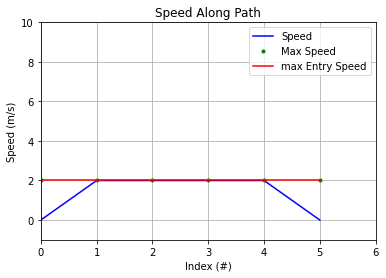

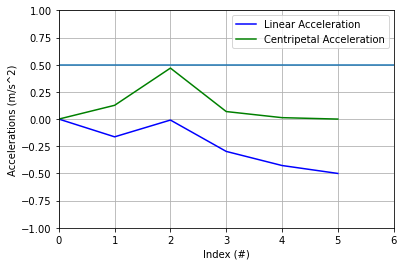

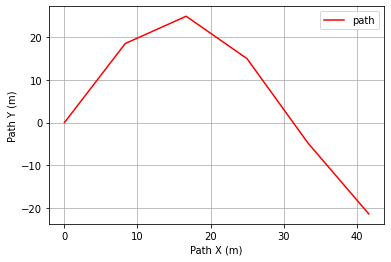

In [608]:
# make path
path = []
for i in range(pnts.shape[1]-1):
    p = PathSegment(i, pnts)
    #p.cout()
    path.append(p)

for si, seg in enumerate(path):
    seg.computeRadiusOfCurvature(si, path)
    seg.initSpeed(si, path, car)


# iterative process of refining path speed
# you shouldn't go faster than the next path will want you to
flag = 1
iter = 0
while flag > 0 and iter < 10:
    # iterate over each segement, if the next segment is moving slower than this one by X, slow down
    flag = 0
    for si, seg in enumerate(path):
        flag += seg.computeSpeed(si, path, car)
        
    print("flag[",iter,"]: ", flag)
    iter+=1
    
# plot speeds
speeds = []
m_speeds = []
rocs = []
xs = []
ys = []
cent_accels = []
lin_accels = []
max_entry_speeds = []
total_time = 0.0
total_dist = 0.0
for p in path:
    max_entry_speeds.append(p.max_entry_speed)
    speeds.append(p.speed)
    m_speeds.append(p.max_speed)
    xs.append(p.p[0])
    ys.append(p.p[1])
    rocs.append(p.radius_of_curvature)
    cent_accels.append(p.centripetal_acceleration)
    lin_accels.append(p.linear_acceleration)
    total_time += p.dt
    total_dist += p.length_m

print("total_time: ", total_time, " s")
print("total_dist: ", total_dist, " m")
print("average speed: ", total_dist / total_time, " m/s")
    
plt.plot(speeds,'b', label="Speed")
plt.plot(m_speeds,'g.', label="Max Speed")
plt.plot(max_entry_speeds,'r', label="max Entry Speed")
plt.title("Speed Along Path")
plt.grid()
plt.ylabel('Speed (m/s)')
plt.xlabel('Index (#)')
plt.axis([0, len(xs), -1, 10])
plt.legend()
plt.show()

plt.plot(lin_accels,'b', label="Linear Acceleration")
plt.plot(cent_accels,'g', label="Centripetal Acceleration")
plt.hlines([car.max_accel], 0, len(xs))
# plt.plot(rocs,'r', label="Radii")
# plt.title("Speed Along Path")
plt.grid()
plt.ylabel('Accelerations (m/s^2)')
plt.xlabel('Index (#)')
plt.axis([0, len(xs), -1, 1])
plt.legend()
plt.show()

plt.plot(xs,ys,'r', label="path")
plt.grid()
plt.ylabel('Path Y (m)')
plt.xlabel('Path X (m)')
plt.legend()
plt.show()

In [582]:
# Function to return the minimum distance
# between a line segment AB and a point E
def minDistance(A, B, E) :
    # vector AB
    AB = np.zeros((2,1))
    AB = B - A

    # vector BP
    BE = np.zeros((2,1))
    BE = E - B

    # vector AP
    AE = np.zeros((2,1))
    AE = E - A
    
    
    # Variables to store dot product

    # Calculating the dot product
    AB_BE = np.dot(AB,BE)
    AB_AE = np.dot(AB,AE)
    
    # Minimum distance from
    # point E to the line segment
    reqAns = 0;

    # Case 1
    if (AB_BE > 0) :

        # Finding the magnitude
        y = E[1] - B[1];
        x = E[0] - B[0];
        reqAns = np.sqrt(x * x + y * y);

    # Case 2
    elif (AB_AE < 0) :
        y = E[1] - A[1];
        x = E[0] - A[0];
        reqAns = np.sqrt(x * x + y * y);

    # Case 3
    else:
        # Finding the perpendicular distance
        x1 = AB[0];
        y1 = AB[1];
        x2 = AE[0];
        y2 = AE[1];
        mod = np.sqrt(x1 * x1 + y1 * y1);
        reqAns = abs(x1 * y2 - y1 * x2) / mod;

    return reqAns;


In [583]:
# find the closest point - moving forward
def findCurrentSegment(c_index, pnts, car):
    d0 = minDistance(pnts[:, c_index], pnts[:, c_index+1], car)
    d1 = d0
    #print(t_index, "DA, DB: ", d0, ", ", d1)

    while d1 <= d0:
        c_index += 1
        d0 = d1
        d1 = minDistance(pnts[:, c_index],pnts[:, c_index+1],car)
        #print(t_index, "DA, DB 2: ", d0, ", ", d1)

    #segment = t_index-1
    #print("best match is segment", segment, "at distance", d0)
    return c_index - 1

In [584]:
# search the current line segement and the next line segment to see where the circle intersects them
# find intersection point for regular line then get distance to intersection point to line segment to make it easier

def getLineEquationFromPoints(pa, pb, car):
    # using equation y=mx + b and then convert to Ax + Bx + c = 0 by setting B=-1 and A=m
    print("getLineEquationFromPoints: pa,pb: ", pa, pb)
    ta = pa - car
    tb = pb - car
    dx = tb[0] - ta[0]
    #print("getLineEquationFromPoints:dx:", dx)
    if dx <= 0.0000001:
        # line is vertical!
        A=-1
        B=0
        C=tb[0]
        return [A,B,C]
    else:
        # line is NOT vertical
        A = (tb[1] - ta[1]) / dx
        B = -1.0
        C = tb[1] - A*tb[0]
        return [A,B,C]

pa:  [16.66666667 24.88519894]
pb:  [25.        14.9618036]
getLineEquationFromPoints: pa,pb:  [16.66666667 24.88519894] [25.        14.9618036]
A,B,C:  -1.1908074409434255 -1.0 3.6678260433019894
xs:  [16.66666667 25.        ]


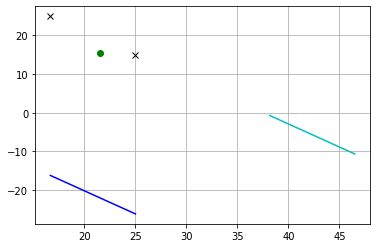

In [585]:
# test the equaion of the line
c = car_p

segment = findCurrentSegment(0, pnts, car_p)
pa = pnts[:,segment]
pb = pnts[:,segment+1]

print("pa: ", pa)
print("pb: ", pb)

[A,B,C] = getLineEquationFromPoints(pa,pb,car_p)
print("A,B,C: ", A,B,C)

xs = np.linspace(pa[0], pb[0], 2)
print("xs: ", xs)
lin = A*xs + C


plt.plot(pa[0],pa[1],'kx')
plt.plot(pb[0],pb[1],'kx')

plt.plot(car_p[0], car_p[1],'go')
plt.plot(xs,lin,'b')
plt.plot(xs+car_p[0],lin+car_p[1],'c')
plt.grid()

In [586]:
def getLineCircleIntersection(r,a,b,c,car):  
    print("in getLineCricleIntersection: (r,a,b,c): ",r,a,b,c)
    x0 = -a*c/(a*a+b*b)
    y0 = -b*c/(a*a+b*b);
    if c*c > r*r*(a*a+b*b)+0.000000001:
        print("no points");
    elif abs (c*c - r*r*(a*a+b*b)) < 0.000000001:
        #print("1 point: ", x0, y0)
        return np.array([x0+car[0],y0+car[1]])
    else:
        d = r*r - c*c/(a*a+b*b)
        mult = np.sqrt(d / (a*a+b*b))
        ax = x0 + b * mult + car[0]
        bx = x0 - b * mult + car[1]
        ay = y0 - a * mult + car[0]
        by = y0 + a * mult + car[1]
        print(" getLineCricleIntersection::2 points: (", ax, ay,"), (", bx,by,")")
        print(" getLineCricleIntersection: car: ", car)
        return np.array([[ax,ay], [bx,by]])

In [587]:
E = np.array([0,0])
L = np.array([10,0])
C = np.array([-0.9,0])
r = 1.0

d = L - E
f = E - C


a = np.dot( d,d ) ;
b = 2*f.dot( d ) ;
c = f.dot( f ) - r*r ;

discriminant = b*b-4*a*c;
if discriminant < 0:
    print("no intersection")
else:
    # ray didn't totally miss sphere,
    # so there is a solution to
    # the equation.

    discriminant = np.sqrt( discriminant );

    # either solution may be on or off the ray so need to test both
    # t1 is always the smaller value, because BOTH discriminant and
    # a are nonnegative.
    t1 = (-b - discriminant)/(2*a);
    t2 = (-b + discriminant)/(2*a);
    print("t1,t2: ", t1, t2)

    # 3x HIT cases:
    #          -o->             --|-->  |            |  --|->
    # Impale(t1 hit,t2 hit), Poke(t1 hit,t2>1), ExitWound(t1<0, t2 hit), 

    # 3x MISS cases:
    #       ->  o                     o ->              | -> |
    # FallShort (t1>1,t2>1), Past (t1<0,t2<0), CompletelyInside(t1<0, t2>1)

    if t1 >= 0 and t1 <= 1 :
        # t1 is the intersection, and it's closer than t2
        # (since t1 uses -b - discriminant)
        # Impale, Poke
        if t2 >= 0 and t2 <= 1:
            p1 = E + t1*d
            p2 = E + t2*d
            print("Impale: ", p1, p2)
        else:
            p1 = E + t1*d
            print("poke: ", p1)
            
    # here t1 didn't intersect so we are either started
    # inside the sphere or completely past it
    elif t2 >= 0 and t2 <= 1:
        p2 = E + t2*d
        print("ExitWound: ", p2)
    else:
        # no intn: FallShort, Past, CompletelyInside
        print("miss")


t1,t2:  -0.19 0.01
ExitWound:  [0.1 0. ]


In [588]:
def lineCircleIntersection(E,L,C,r):
    # E := init point
    # L := end point
    # C := circle center point
    # r := radius
    # intersection point P = E + t*d
    d = L - E
    f = E - C


    a = np.dot( d,d ) ;
    b = 2*f.dot( d ) ;
    c = f.dot( f ) - r*r ;

    discriminant = b*b-4*a*c;
    if discriminant < 0:
        print("no intersection")
        return 0, []
    else:
        # ray didn't totally miss sphere,
        # so there is a solution to
        # the equation.

        discriminant = np.sqrt( discriminant );

        # either solution may be on or off the ray so need to test both
        # t1 is always the smaller value, because BOTH discriminant and
        # a are nonnegative.
        t1 = (-b - discriminant)/(2*a);
        t2 = (-b + discriminant)/(2*a);
        print("t1,t2: ", t1, t2)

        # 3x HIT cases:
        #          -o->             --|-->  |            |  --|->
        # Impale(t1 hit,t2 hit), Poke(t1 hit,t2>1), ExitWound(t1<0, t2 hit), 

        # 3x MISS cases:
        #       ->  o                     o ->              | -> |
        # FallShort (t1>1,t2>1), Past (t1<0,t2<0), CompletelyInside(t1<0, t2>1)

        if t1 >= 0 and t1 <= 1 :
            # t1 is the intersection, and it's closer than t2
            # (since t1 uses -b - discriminant)
            # Impale, Poke
            if t2 >= 0 and t2 <= 1:
                p1 = E + t1*d
                p2 = E + t2*d
                print("Impale: ", p1, p2)
                return 2, [p1,p2]
            else:
                p1 = E + t1*d
                print("poke: ", p1)
                return 1, [p1]
        # here t1 didn't intersect so we are either started
        # inside the sphere or completely past it
        elif t2 >= 0 and t2 <= 1:
            p2 = E + t2*d
            print("ExitWound: ", p2)
            return 1, [p2]
        else:
            # no intn: FallShort, Past, CompletelyInside
            print("miss")
            return 0, []

In [589]:
def circle_from_3_points(z1:complex, z2:complex, z3:complex) -> tuple[complex, float]:
    # https://math.stackexchange.com/questions/213658/get-the-equation-of-a-circle-when-given-3-points#:~:text=Follow%20these%20steps%3A%201%20Consider%20the%20general%20equation,%E2%88%92%20yc%292%20%E2%88%92%20r2%20%3D%200%20More%20items
    if (z1 == z2) or (z2 == z3) or (z3 == z1):
        raise ValueError(f"Duplicate points: {z1}, {z2}, {z3}")
        
    w = (z3 - z1)/(z2 - z1)
    
    # You should change 0 to a small tolerance for floating point comparisons
    if abs(w.imag) <= 0.001:
        # return np.mean(np.array([z1,z2,z3])), np.Inf
        raise ValueError(f"Points are collinear: {z1}, {z2}, {z3}")
        
    c = (z2 - z1)*(w - abs(w)**2)/(2j*w.imag) + z1;  # Simplified denominator
    r = abs(z1 - c)
    
    return c, r

# z1:  0j
# z2:  (18.75+19.34320954324428j)
# z3:  (37.5+37.5j)
# c:  (611.0981090630455-573.5981090630454j)
# r:  838.1262969392686

print(circle_from_3_points(0j, 18.75 + 19.34j, 37.5+37.5j))  # Can also generate 1+1j with `complex(1,1)`

((614.3236440677967-576.8236440677967j), 842.6856211045666)


In [590]:
def speed_tuning_binary_search(radius, max_speed, dist, max_accel):
    # start with initial speed being the maximum acheivable acceleration at the final speed    
    centr_accel = max_speed**2 / radius
    if centr_accel > max_accel:
        print("Max speed exceeded limit, setting to max acheivable")
        max_speed = math.sqrt(max_accel * radius)

    speed_ul = max_speed + max_accel * dist / max_speed
    
    # check if I should bail out early and just use max accel
    if speed_ul**2 / radius < 0.01:
        # centripetal acceleration has ~0 effect, so I can exit early
        return speed_ul, max_speed
    
    # centripetal acceleration has an effect - enter the binary search
    speed_ll = max_speed
    
    while speed_ul - speed_ll > 0.01:
        # ul is known to be to high - check middle limit
        speed_ml = (speed_ul + speed_ll) / 2.0
        lin_accel = (max_speed**2 - speed_ml) / (2.0 * dist)
        centr_accel = speed_ml**2 / radius
        if lin_accel + centr_accel > max_accel:
            speed_ul = speed_ml
        else:
            speed_ll = speed_ml
            
        
    # return the average of speed_ul and speed_ll as well as final speed
    return (speed_ul + speed_ll) / 2.0, max_speed


si, s = speed_tuning_binary_search(radius=1.0, max_speed=2, dist=1.0, max_accel=0.5)
print("speed_in: ", si, " and speed out: ", s)

Max speed exceeded limit, setting to max acheivable
speed_in:  0.8093058081549156  and speed out:  0.7071067811865476


In [591]:
for i in range(10):
    si, s = speed_tuning_binary_search(radius=10000, max_speed=2, dist=1.0, max_accel=0.5)


t1,t2:  -0.19 0.01
ExitWound:  [0.1 0. ]
nps:  1
ps:  [array([0.1, 0. ])]
p:  <__main__.PathSegment object at 0x0000021047EC3310>
pa:  [16.66666667 24.88519894]
pb:  [25.        14.9618036]


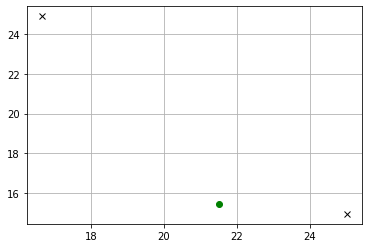

In [592]:
# verify line circle intersections
E = np.array([0,0])
L = np.array([10,0])
C = np.array([-0.9,0])
r = 1.0
nps, ps = lineCircleIntersection(E,L,C,r)

print("nps: ", nps)
print("ps: ", ps)

print("p: ", p)
print("pa: ", pa)
print("pb: ", pb)

plt.plot(pa[0],pa[1],'kx')
plt.plot(pb[0],pb[1],'kx')
# plt.plot(p[0][0],p[0][1],'rx')
# plt.plot(p[1][0],p[1][1],'rx')
plt.plot(car_p[0], car_p[1],'go')
# plt.plot(xs,ys,'b')
plt.grid()

In [593]:
def downSampleIntersectionPoints(goal_p, p):
    print("downSampleIntersectionPoints: goal_p",goal_p)
    print("downSampleIntersectionPoints: p",p)
    if p.shape[0] == 1:
        # only have one point, return p
        return p
    elif p.shape[0] == 2:
        # find the closer intersection to the segment end
        d0 = np.linalg.norm(goal_p-p[0,:])
        d1 = np.linalg.norm(goal_p-p[1,:])
        #print("downSampleIntersectionPoints: d0, d1",d0,d1)
        if d0 < d1:
            #print("downSampleIntersectionPoints: p[0,:]",p[0,:])
            return p[0,:]
        else:
            #print("downSampleIntersectionPoints: p[1,:]",p[1,:])
            return p[1,:]
    else:
        print("downSampleIntersectionPoints: 0 intersection points")
        return -1    

getLineEquationFromPoints: pa,pb:  [16.66666667 24.88519894] [25.        14.9618036]
findFwdAnchorPoint: A,B,C: -1.1908074409434255 -1.0 3.6678260433019894
in getLineCricleIntersection: (r,a,b,c):  5.0 -1.1908074409434255 -1.0 3.6678260433019894
 getLineCricleIntersection::2 points: ( 20.47114027200823 26.392999863081613 ), ( 20.103263953448458 13.602544123265378 )
 getLineCricleIntersection: car:  [21.5       15.4618036]
downSampleIntersectionPoints: goal_p [25.        14.9618036]
downSampleIntersectionPoints: p [[20.47114027 26.39299986]
 [20.10326395 13.60254412]]
p_fwd:  [20.10326395 13.60254412]
segment_index: 2


ValueError: x and y must have same first dimension, but have shapes (2,) and (6,)

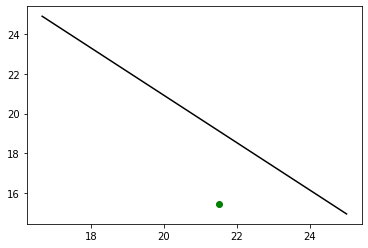

In [594]:
# complete function to find segmentand goal point on segment
def findFwdAnchorPoint(car, l_fwd, pnts, segment_index):
    #print("findFwdAnchorPoint: car: ", car)
    #print("findFwdAnchorPoint: l_fwd: ", l_fwd)
    #print("findFwdAnchorPoint: pnts: ", pnts)
    #print("findFwdAnchorPoint: segment_index: ", segment_index)
    # find what segment I am on, starting from current index
    segment_index = findCurrentSegment(segment_index, pnts, car_p)
    #print("findFwdAnchorPoint: found segment: ", segment)
    # get line slop of c_index segment
    pa = pnts[:,segment_index]
    pb = pnts[:,segment_index+1]
    [A,B,C] = getLineEquationFromPoints(pa,pb,car_p)
    print("findFwdAnchorPoint: A,B,C:", A,B,C)  
    # get proposed anchor points of segment
    p = getLineCircleIntersection(l_fwd,A,B,C, car_p)
    #print("findFwdAnchorPoint: p:", p)
    # check if there is 1 or 2 intersections
    #print("findFwdAnchorPoint: pnts[segment+1,:]:", pnts[:,segment+1])
    p_out = downSampleIntersectionPoints(pnts[:,segment_index+1], p)
    #print("findFwdAnchorPoint: p_out:", p_out)
    return segment_index, p_out
    
segment_index, p_fwd = findFwdAnchorPoint(car, 5.0, pnts, 0)

print("p_fwd: ", p_fwd)
print("segment_index:", segment_index)

plt.plot([pa[0], pb[0]], [pa[1], pb[1]],'k')
# plt.plot(p[0].p[0],p[0].p[1],'rx')
# plt.plot(p[1][0],p[1][1],'rx')
plt.plot(car_p[0], car_p[1],'go')
plt.plot(xs,ys,'b')
plt.plot(p_fwd[0], p_fwd[1],'ro')
plt.grid()

In [ ]:
# check and see if the intersection point is on this segment of the next one!
# this checks if the distance from me to the goal point is closer than me to
# the ennd segment point
dist_goal = np.linalg.norm(car_p - p_fwd)
dist_end = np.linalg.norm(car_p - pnts[:,segment+1])

print("dist_goal:", dist_goal)
print("dist_end:", dist_end)

l_fwd = 5.0
segment_index = 3

if dist_goal > dist_end:
    segment_index += 1
    print("segment_index: ", segment_index)
    # need to find aim point on next segment
    pa = pnts[:,segment_index]
    pb = pnts[:,segment_index+1]
    [A,B,C] = getLineEquationFromPoints(pa,pb,car_p)
    print("findFwdAnchorPoint: A,B,C:", A,B,C)  
    # get proposed anchor points of segment
    p = getLineCircleIntersection(l_fwd,A,B,C, car_p)
    print("findFwdAnchorPoint: p:", p)
    # check if there is 1 or 2 intersections
    #print("findFwdAnchorPoint: pnts[segment+1,:]:", pnts[:,segment+1])
    p_out = downSampleIntersectionPoints(pnts[:,segment_index+1], p)
    print("findFwdAnchorPoint: p_out:", p_out)
    





dist_goal: 13.191569721315048
dist_end: 3.5355339059327378
segment_index:  4
getLineEquationFromPoints: pa,pb:  [4.08163265 9.92310372] [ 5.10204082 12.2088837 ]
findFwdAnchorPoint: A,B,C: 2.2400643734085524 -1.0 -8.236992315538258
in getLineCricleIntersection: (r,a,b,c):  5.0 2.2400643734085524 -1.0 -8.236992315538258
 getLineCricleIntersection::2 points: ( 1.117083288980764 -5.190543959634155 ), ( 12.610413819095625 10.048356691756728 )
 getLineCricleIntersection: car:  [-0.43877551  8.03409076]
findFwdAnchorPoint: p: [[ 1.11708329 -5.19054396]
 [12.61041382 10.04835669]]
downSampleIntersectionPoints: goal_p [ 5.10204082 12.2088837 ]
downSampleIntersectionPoints: p [[ 1.11708329 -5.19054396]
 [12.61041382 10.04835669]]
findFwdAnchorPoint: p_out: [12.61041382 10.04835669]


In [ ]:
sys.path.insert(0, os.path.abspath('./..'))

In [ ]:
import jupylet.color

from jupylet.app import App
from jupylet.state import State
from jupylet.label import Label
from jupylet.sprite import Sprite

In [ ]:
app = App(width=800, height=800)#log_level=logging.INFO)

In [ ]:
background = '#3e32a2'
foreground = '#7c71da'

body_im = np.ones((20, 120)) * 255
wheel_im = np.ones((15,40)) * 255
a2 = np.ones((app.height * 9 // 10, app.width * 9 // 10, 3)) * 255
course_im = np.ones((2,300))*255

body = Sprite(body_im, y=app.height/2, x=app.width/2)
f_wheel = Sprite(wheel_im, y=app.height/2, x=app.width/2+60, color=foreground)
r_wheel = Sprite(wheel_im, y=app.height/2, x=app.width/2-60, color=foreground)
course = Sprite(course_im, y=600,x=400,color='white')
field = Sprite(a2, y=app.height/2, x=app.width/2, color=background)

In [ ]:
speed = Label(
    '0', font_size=22, color=foreground, 
    x=100, y=20,
    anchor_y='center', anchor_x='left'
)

steering_angle = Label(
    '0', font_size=22, color=foreground, 
    x=100, y=44, 
    anchor_y='center', anchor_x='left'
)

In [ ]:
@app.event
def render(ct, dt):
    
    app.window.clear(color=foreground)
    field.draw()
    course.draw()
    body.draw()
    f_wheel.draw()
    r_wheel.draw()
    speed.draw()
    steering_angle.draw()

In [ ]:
state = State( 
    x = app.width / 2,
    y = app.height / 2,
    
    body_angle = 0.0,
    steering_angle = 0.0,
    
    l = 50.0,
    speed = 0.0,
    speed_error_sum = 0.0,
    
    turn_left = False,
    turn_right = False,

    speed_up = False,
    slow_down = False,
)

In [ ]:
@app.event
def key_event(key, action, modifiers):
        
    keys = app.window.keys
    
    if action == keys.ACTION_PRESS:
        
        if key == keys.LEFT:
            state.turn_left = True

        if key == keys.RIGHT:
            state.turn_right = True

        if key == keys.UP:
            state.speed_up = True

        if key == keys.DOWN:
            state.slow_down = True

    if action == keys.ACTION_RELEASE:
        if key == keys.LEFT:
            state.turn_left = False

        if key == keys.RIGHT:
            state.turn_right = False

        if key == keys.UP:
            state.speed_up = False

        if key == keys.DOWN:
            state.slow_down = False

In [ ]:
def lookupSpeed(path, la_sgmnt, la_t):
    ### this looks at the path at line segment and line  segment + 1 and lineraly interpolates based on la_t
    # - path := list of path segments
    # - la_sgment := which path segment in path I am on
    # - la_t := dist along la_t between 0 and 1
    
    if la_sgmnt + 1 < len(path):
        speed_out = (1.0-la_t) * path[la_sgmnt].speed + la_t * path[la_sgmnt+1].speed
        return speed_out
    else:
        speed_out = (1.0-la_t) * path[la_sgmnt].speed # + la_t * 0.0 (stop!)
        return speed_out
        

In [ ]:
@app.run_me_every(1/20)
def veh_controller(ct,dt):
    
    ### use current speed to get lookahead distance
    Lfw = 3.0 # state.speed < 1.34 use 3.0 per paper
    if state.speed >= 1.34 and state.speed < 5.36: # 1.34 <-> 5.36 use 2.24 * speed
        Lfw = 2.24 * state.speed
    elif state.speed >= 5.36: # greater than 5.36, use 12.0
        Lfw = 12.0
    
    ### use position, get forward look ahead point at look ahead
    # - get axis point in my frame
    # - get point on circle (r=lookahead dist) that intersects path
    la_pnt = np.zeros((2,1)) # lookahead point
    la_t = 0.0
    la_sgmnt = 0 # look ahead segment index
    [la_pnt, la_sgmnt, la_t] = getLookaheadPoint(path, state, la_sgmnt)
    
    ### use look ahead point to find steering angle
    # - L = wheel base
    # - n = heading of look ahead pnt w.r.t. vehicle heading
    # - Lfw = lookahead distance
    # - lfw = distance from rear axle to forward anchor point
    state.steering_angle = -atan((L*sin(n)) / (0.5*Lfw + lfw*cos(n)))
    
    ### use look ahead point to find desired speed
    # - interpolate between nodes to find the desired speed - linear across segments. someday quadratic?
    speed_desired = lookupSpeed(path, la_sgmnt, la_t)
    
    
    ### use desired speed to conrol speed
    Kp = 0.2 # 0.2 from paper
    Ki = 0.04 # 0.04 from paper
    speed_error = speed_desired - state.speed
    state.speed_error_sum += speed_error
    # - constrain integral
    state.speed_error_sum = min(state.speed_error_sum, 50.0)
    state.speed_error_sum = max(state.speed_error_sum, -50.0)
    # - PI speed controller
    u = Kp * speed_error + Ki * state.speed_error_sum
    # - update speed
    state.speed += u*dt

In [ ]:
@app.run_me_every(1/120)
def update_pads(ct, dt):
    # account for user inputs
    if state.turn_right:
        state.steering_angle += 0.05
        
    if state.turn_left:
        state.steering_angle -= 0.05
        
    if state.speed_up:
        state.speed += 1.0
        
    if state.slow_down:
        state.speed -= 1.0
    
    # constrain the solution
    state.steering_angle = min(3.14159/3.0, state.steering_angle)
    state.steering_angle = max(-3.14159/3.0, state.steering_angle)
    state.speed = min(50.0, state.speed)
    state.speed = max(0.0, state.speed)
    
    # apply kindematic equations
    vx = state.speed * math.cos(state.body_angle)
    vy = state.speed * math.sin(state.body_angle)
    vt = state.speed / state.l * math.tan(state.steering_angle)
    
    state.x += vx * dt
    state.y += vy * dt
    state.body_angle -= vt * dt
    
    body.x = state.x
    body.y = state.y
    body.angle = state.body_angle*180.0/3.14159
    
    r_wheel.x = body.x - 50.0*math.cos(state.body_angle)
    r_wheel.y = body.y - 50.0*math.sin(state.body_angle)
    r_wheel.angle = body.angle
    f_wheel.x = body.x + 50.0*math.cos(state.body_angle)
    f_wheel.y = body.y + 50.0*math.sin(state.body_angle)
    f_wheel.angle = body.angle - state.steering_angle*180/3.14519
    
    body.clip_position(app.width, app.height)
    
    speed.text = str(vt*dt)
    steering_angle.text = str(state.steering_angle*180/3.14159)
    speed.color = 'white'
    steering_angle.color = 'white'
    

In [ ]:
@app.run_me
def highlights(ct, dt):
    while True:
        ct, dt = yield 1/24
        speed.color = 'white'
        steering_angle.color = 'white'
        

In [ ]:
app.run()